# Traning an MLP to classify MNIST data using Backpropagation in Numpy

The purpose of this problem is to program, using `numpy` package, the training for a multilayer perceptron (MLP) deep neural network. Special Deep Learning Toolbox libraries such as `tf.keras`, `pythorch`, `scikitlearn`, etc are not to be used here, so that we practice the backpropagation operations in obtaining the network slope and offset parameters.

---

The data used here is MNIST image classification for numbers. Each of `mnist_train.csv` and `mnist_test.csv` are data frames with 60,000 and 10,000 rows representing number of observations, respectively. Both these data frames consist of 785 columns. The first column is the label of the image representing the true number the image is supposed to show, and the following 784 columns are the reshaped 28x28 pixels of the images each showing a number between 0 and 255 representing a color code.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Deep Learning Colab/MNIST/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  # !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)

os.getcwd()


Your working directory was changed to /content/drive/My Drive/Deep Learning Colab/MNIST/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


'/content/drive/My Drive/Deep Learning Colab/MNIST'

## Import the Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import time
from scipy.special import softmax
import random
import zipfile

## Define the Required Activation Functions

In [6]:
# Define activation functions
def ReLU(x):
  return np.maximum(0,x)

def ReLU_dot(x):
  x_tmp = np.ones(x.shape)
  x_tmp[x>0] = 1
  x_tmp[x<=0] = 0
  return x_tmp

def tanh(x):
  return np.tanh(x)

def tanh_dot(x):
  return 1-tanh(x)**2

def SoftMax_vec(x):
  x_tmp = x - np.max(x, axis=0)
  return np.exp(x_tmp)/np.sum(np.exp(x_tmp), axis=0)

## Load the Data

In [19]:
# Load the data
with zipfile.ZipFile('MNIST_CSV.zip') as myZip:
    with myZip.open('mnist_train.csv') as myZipCsv:
        traindata = np.array( pd.read_csv(myZipCsv, header=None) )
    with myZip.open('mnist_test.csv') as myZipCsv:
        testdata = np.array( pd.read_csv(myZipCsv, header=None) )

len_onehot = traindata[:,0].max() - traindata[:,0].min() + 1

train_y = np.zeros((len(traindata),len_onehot))
train_y[range(len(traindata)), traindata[:,0]] = 1

test_y = np.zeros((len(testdata),len_onehot))
test_y[range(len(testdata)), testdata[:,0]] = 1

traindata = np.hstack([traindata[:,1:], train_y])
testdata  = np.hstack([testdata[:,1:], test_y])

The data in `traindata` need to be split into a training set and a validation set. The `testdata` will not be touched until once training the MLP is complete.

The training/validation split used here is 80/20%. We use random sampling to sample 20% of the data in `traindata` and assign it to the validation set (`val_set`). The rest (80% or 48,000 data) of `traindata` is used as the training set (`train_set`).

In [20]:
val_indices = random.sample(range(0, len(traindata)), len(traindata)//5)

val_set = traindata[val_indices,:]
train_set = np.delete(traindata,val_indices, axis=0)

## Training the MLP for MNIST Data

#### The Parameters for the MLP Architecture

In [24]:
# NN architecture
batch_size = 48
batch_no = 1000
eta0 = .001
activation = 'ReLU'
activation = 'tanh'
neuron1 = 60

#### Weights and Biases Initialization

In [25]:
# Weights and biases initialization
W1 = np.random.randn(neuron1, 784)*(1/784)
W2 = np.random.randn(10, neuron1)*(1/neuron1)
b1 = np.random.randn(neuron1,1)*(1/784)
b2 = np.random.randn(10,1)*(1/neuron1)

In [26]:
eta = eta0
train_acc = np.zeros((50,1))
val_acc = np.zeros((50,1))

for epoch in range(50):
  t_epoch = time.time()
  if epoch>=20:
    eta = eta0/2
  elif epoch>=40:
    eta = eta0/4

  np.random.shuffle(train_set)

  for B in range(batch_no):
    X_batch = train_set[B*batch_size:(B+1)*batch_size , 0:-10]
    y_batch = np.asarray(train_set[B*batch_size:(B+1)*batch_size , -10:]).reshape(batch_size,10)
    x = X_batch
    y = y_batch

    a1 = ReLU(W1@x.T + b1.reshape(neuron1,1))
    a1_dot = ReLU_dot(a1)
    a2 = SoftMax_vec(W2@a1 + b2)

    delta2 = a2 - y.T
    delta1 = a1_dot*(W2.T@delta2)

    W1grad = delta1@x/batch_size
    W2grad = delta2@a1.T/batch_size
    b1grad = np.mean(delta1,axis=1).reshape(neuron1,1)
    b2grad = np.mean(delta2,axis=1).reshape(10,1)

    W1 = W1 - eta*W1grad
    W2 = W2 - eta*W2grad
    b1 = b1 - eta*b1grad
    b2 = b2 - eta*b2grad

  # forward NN on training set
  x = np.array(train_set[:,0:-10])
  y = np.array(train_set[:,-10:])
  a1 = ReLU(W1@x.T + b1.reshape(neuron1,1))
  a2 = SoftMax_vec(W2@a1 + b2)
  decision_train = np.argmax(a2, axis=0)
  labels_train = np.argmax(y.T, axis=0)
  # forward NN on validation set
  x = np.array(val_set[:,0:-10])
  y = np.array(val_set[:,-10:])
  a1 = ReLU(W1@x.T + b1.reshape(neuron1,1))
  a2 = SoftMax_vec(W2@a1 + b2)
  decision_val = np.argmax(a2, axis=0)
  labels_val = np.argmax(y.T, axis=0)

  # Online report of the learning for each epoch
  train_acc[epoch] = (1-np.mean(decision_train!=labels_train))*100
  val_acc[epoch] = (1-np.mean(decision_val!=labels_val))*100
  print('Epoch ', epoch+1,'/50 : Train. Acc. = %',"%0.2f" % (train_acc[epoch]), ' // Val. Acc. = %',"%0.2f" % (val_acc[epoch]), ' -- el_time = ', "%0.2f" % (time.time()-t_epoch), 'sec')

Epoch  1 /50 : Train. Acc. = % 95.06  // Val. Acc. = % 94.57  -- el_time =  4.18 sec
Epoch  2 /50 : Train. Acc. = % 96.56  // Val. Acc. = % 95.85  -- el_time =  2.18 sec
Epoch  3 /50 : Train. Acc. = % 96.83  // Val. Acc. = % 95.83  -- el_time =  2.29 sec
Epoch  4 /50 : Train. Acc. = % 97.38  // Val. Acc. = % 96.14  -- el_time =  2.28 sec
Epoch  5 /50 : Train. Acc. = % 97.89  // Val. Acc. = % 96.63  -- el_time =  2.20 sec
Epoch  6 /50 : Train. Acc. = % 98.06  // Val. Acc. = % 96.52  -- el_time =  3.77 sec
Epoch  7 /50 : Train. Acc. = % 98.49  // Val. Acc. = % 96.69  -- el_time =  3.64 sec
Epoch  8 /50 : Train. Acc. = % 98.53  // Val. Acc. = % 96.71  -- el_time =  2.35 sec
Epoch  9 /50 : Train. Acc. = % 98.73  // Val. Acc. = % 96.75  -- el_time =  2.39 sec
Epoch  10 /50 : Train. Acc. = % 98.64  // Val. Acc. = % 96.48  -- el_time =  2.29 sec
Epoch  11 /50 : Train. Acc. = % 98.88  // Val. Acc. = % 96.75  -- el_time =  2.72 sec
Epoch  12 /50 : Train. Acc. = % 98.99  // Val. Acc. = % 96.81  

In [30]:
# forward NN on thetest set
X_test = testdata[:,:-10]
y_test = testdata[:,-10:]

x = X_test
y = y_test

a1 = ReLU(W1@x.T + b1.reshape(neuron1,1))
a2 = SoftMax_vec(W2@a1 + b2)
decision_test = np.argmax(a2, axis=0)
labels_test = np.argmax(y.T, axis=0)
test_accuracy = (1-np.mean(decision_test!=labels_test))*100

print('The prediction accuracy on the Test set is  =  ', test_accuracy)

The prediction accuracy on the Test set is  =   97.44


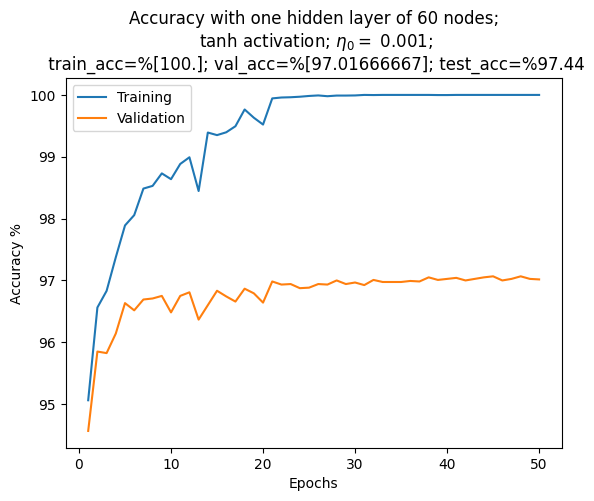

In [31]:
# Plot learning curve : accuracy%
plt.figure(1)
plt.plot(np.arange(1,51), train_acc, label='Training')
plt.plot(np.arange(1,51), val_acc, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.title(f'Accuracy with one hidden layer of {neuron1} nodes;\n {activation} activation; $\eta_0=$ {eta0};\n train_acc=%{train_acc[-1]}; val_acc=%{val_acc[-1]}; test_acc=%{test_accuracy}')
plt.legend()
plt.show()

## Visualizing some of the Correct and Misclassified Images

1. Let us first take a look at some correctly classified examples.

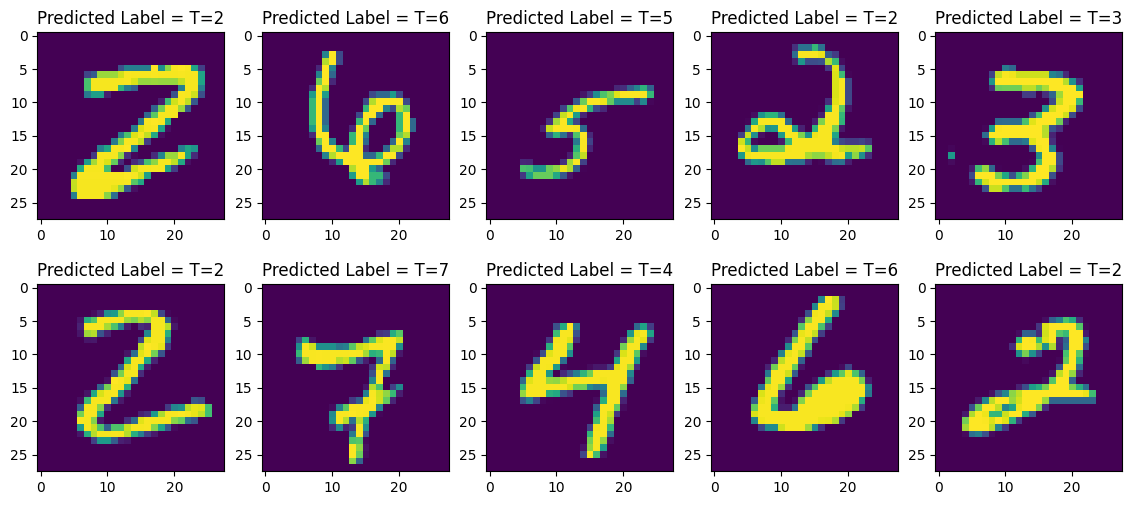

In [44]:
# Find indices for correct and incorrect predictions and sample plot them
correct_indices = np.where(np.equal(decision_test, labels_test))[0]
correct_indices_sampl = np.random.choice(correct_indices,10)

plt.figure(figsize=(14,6))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(X_test[correct_indices_sampl[i]].reshape(28,28))
  plt.title('Predicted Label = T=%i' %decision_test[correct_indices_sampl[i]])
plt.show()

2. Now let us take a look at some examples of misclassification and understand what could be the reason for the misclassifications made aside from the predictive power of the architectured MLP.

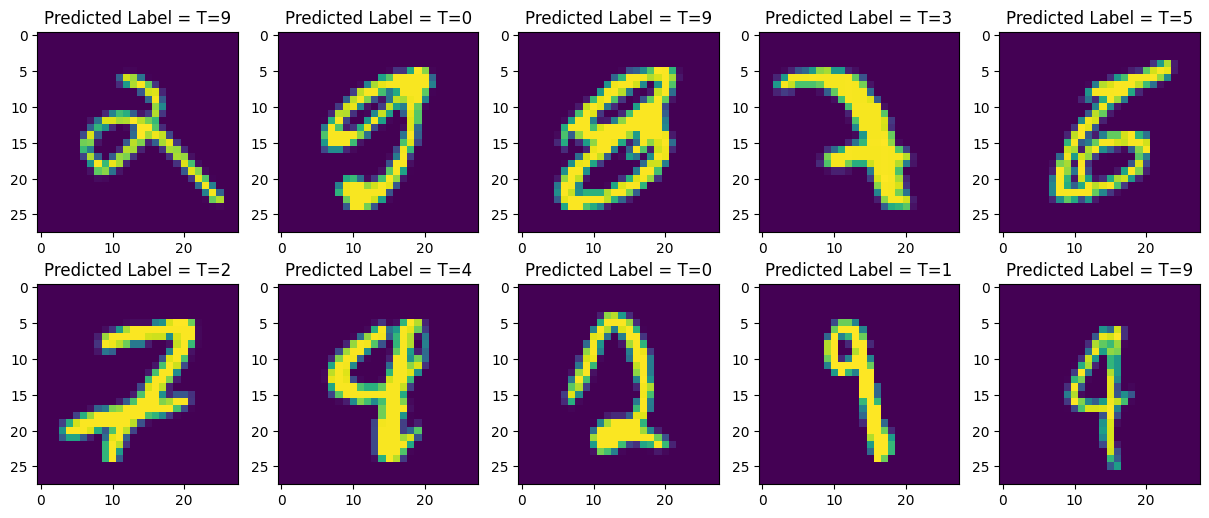

In [42]:
incorrect_indices = np.where(decision_test!=labels_test)[0]
incorrect_indices_sampl = np.random.choice(incorrect_indices,10)

plt.figure(figsize=(14,6))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(X_test[incorrect_indices_sampl[i]].reshape(28,28))
  plt.title('Predicted Label = T=%i' %decision_test[incorrect_indices_sampl[i]])
plt.show()

As you can see, the quality of examples in some cases could have confused the MLP training as some of the images labeled with their true values do not really look like their true labels. For instance, the bottom row of the figure above points at examples of images representing `7` written in a way that could be confused with a `2`. Examples of images representing a `9` also have happened to be written in a way that could be confused with a `1` and `4`.

In conclusion, one could say that the prediction accuracy of `100%`, `~97%` and `~97.5%` for the training, validation and test sets achieved by the designed MLP here are within acceptable accuracy ranges.